# Tehisintellekti 7. kodutöö - linnuliigi ennustamine heliklipi alusel
## Baseerub Kaggle'i võistlusel BirdCLEF 2024
### Autorid: Charleen Konsa, Timo Kaasik ja Edvard Notberg

Seitsmenda kodutöö raames lahendasime Kaggle'i võistluse BirdCLEF 2024 lihtsustatud versiooni. Võistluse info asub lingil https://www.kaggle.com/competitions/birdclef-2024. Kõik kasutatud andmed on võetud võistluse lehelt. Kuna võistluse koguandmestik oli väga mahukas (182 linnuliiki ja heliklippe 7+ GB mahus), siis on kasutatud ainult osa kõigist andmetest. Meie kasutatud andmed on üles laetud GitHubi repositooriumisse (link - https://github.com/Ckonsa/AI_KT_7), et oleks ühtselt mõistetav, mis andmeid ja mis mahus on töös kasutatud.

Töö eesmärk on kasutada masinõpet, et tuvastada heliklipi abil India linnuliike. Etteantud klipi puhul klassifitseeritakse, millisele linnuliigile klipis kõlav heli kuulub.

### Vajalikud installeerimised ja impordid

In [1]:
# Vajalikud installimised
!pip install tensorflow-io
!pip install tensorflow --upgrade

In [2]:
# Impordid
import pandas as pd
import ast
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import Audio
import random
import numpy as np
import glob
# Colabi jaoks
import os
from google.colab import drive
# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

In [3]:
# Colabi mount
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


### Andmete analüüs
Esmalt laeme alla informatisooni failist train_metadata.csv. Selles hoiustatakse informatsiooni kõigi treeninghelikilppide kohta. Uurime ja analüüsime täpsemalt etteantud klippide informatsiooni, et paremini mõista, milliste andmetega tegutseme.

NB! Analüüsis on kaasatud kõigi treeningandmete metaandmed. Mudelite juures on kasutatud ainult väikest osa kõigist andmetest. Seega kõigi andmete pealt tehtud järeldused ei kandu üle tegelikult kasutatud andmetele.

In [4]:
metadata = pd.read_csv("train_metadata.csv")
print(f"Informatsiooni andmestiku suurus on {metadata.shape}. Seega on meil esialgu {metadata.shape[0]} heliklippi.")
print(f"Andmestikus on olemas veerud {list(metadata.columns)}.")
metadata.info()

Informatsiooni andmestiku suurus on (24459, 12). Seega on meil esialgu 24459 heliklippi.
Andmestikus on olemas veerud ['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'rating', 'url', 'filename'].
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  f

Heliklippide informatsioon on jaotatud 12-sse tulpa. Kõigi tulpade informatsiooni pole aga tarvis seega on mõislik andmestikku eelnevalt korrastada. Lisaks on mõnes tulbas (latitude ja longitude) osa informatsioonist puudu, mis tuleb enne sobival viisil täita.

Eemaldatavate tulpade hulgas on järgnevad:


*   secondary_label
*   scientific_name
*   common_name
*   author
*   license
*   url

Treenimisel hakatakse ennustama tulpa primary_label, kus on linnu kohta käiv märgend. Kuna linnu märgend on olemas, siis pole masinõppe jaoks tarvis teada linnu teaduslikku ega inimkeelset nime. Samuti on muu informatsioon autori, litsentsi kui ka heliklipi URLi kohta ebavajalik, sest neid ei saa treenimisel kasutada.

Reitingut on võimalik kasutada, et kaasata treenimisele ainult heliklippe, mille kvaliteet on parem. Sel juhul antakse mudelile selgema linnulauluga klipid ja selle alusel on mudelil lihtsam õppida lindude hääli.

In [5]:
# Ebavajalike veergude eemldamine
metadata = metadata.drop(["secondary_labels", "scientific_name", "common_name", "author", "license", "url"], axis = 1)
# Parema reitinguga heliklippide valimine
threshold = 3.0
metadata = metadata[metadata["rating"] >= threshold]
print(f"Informatsiooni andmestiku suurus on nüüd {metadata.shape}.")
# Enam pole rating veeru vaja ehk eemaldame ka selle
metadata = metadata.drop(["rating"], axis = 1)

Informatsiooni andmestiku suurus on nüüd (21506, 6).


In [6]:
# Latitude ja longitude Nan väärtuste väärtustamine
# Asendusväärtusteks võetakse keskmised väärtused
metadata["latitude"].fillna(metadata["latitude"].mean(), inplace=True)
metadata["longitude"].fillna(metadata["longitude"].mean(), inplace=True)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21506 entries, 0 to 24458
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primary_label  21506 non-null  object 
 1   type           21506 non-null  object 
 2   latitude       21506 non-null  float64
 3   longitude      21506 non-null  float64
 4   filename       21506 non-null  object 
dtypes: float64(2), object(3)
memory usage: 1008.1+ KB


In [7]:
# Veeru type listiks muutmine
metadata["type"] = metadata["type"].apply(ast.literal_eval)
# Leiame, mis on 10 enimlevinud type väärtused ja viima iga väärtuse veeru kujule
type_count = Counter([item.lower() for sublist in metadata["type"] for item in sublist])
types = list(dict(sorted(type_count.items(), key=lambda item: item[1], reverse=True)).keys())
# Eemaldame tühja tüübi ja valime 10 kõige sagedasemat tüüpi
types.remove("")
frequent_types = types[:10]
# Iga tüübi jaoks luuakse veerg. Veerus on 1 kui see tüüp oli esialgses listis, muul juhul on 0
for frequent_type in frequent_types:
    metadata[frequent_type] = metadata["type"].apply(lambda x: 1 if frequent_type in [item.lower() for item in x] else 0)
# Eemaldame esialge type veeru
metadata = metadata.drop(["type"], axis = 1)

Edasi analüüsin alles jäänud heliklippide informatsiooni, et näha kas andmed on tasakaalus ja millised andmetega on täpselt tegu. Kuna allesjäänud veerge on vähe, siis pole keeruline neisse süüvida.

Erinevaid linnuliike on kokku 182.


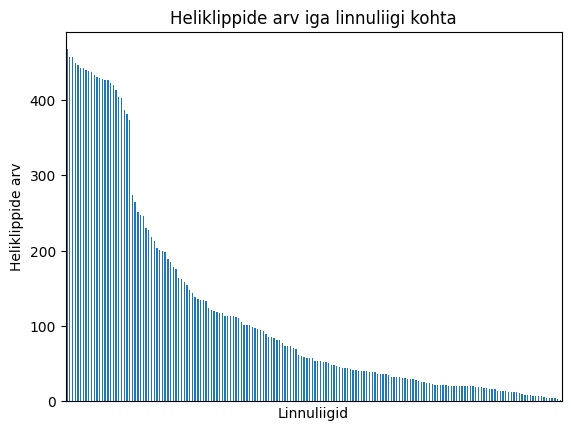

In [8]:
# Treeningandmete tasakaalukus linnuliikide alusel
bird_types = metadata["primary_label"].value_counts()
print(f"Erinevaid linnuliike on kokku {len(bird_types)}.")

bird_types.plot(kind="bar")
plt.title("Heliklippide arv iga linnuliigi kohta")
plt.xlabel("Linnuliigid")
plt.ylabel("Heliklippide arv")
plt.xticks([]) # Muidu proovitakse kõigi linnuliikide märgendeid kuvada
plt.show()

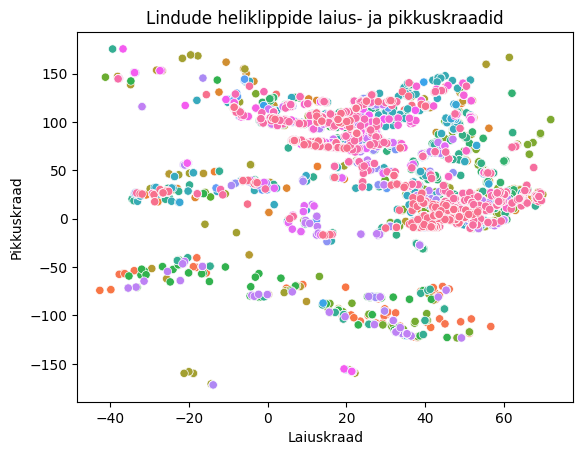

In [9]:
# Andmestikus olevad pikkus- ja laiuskraadi ning linnuliigi sõltuvus neist
sns.scatterplot(data=metadata, x="latitude", y="longitude", hue="primary_label", legend=False)
plt.title("Lindude heliklippide laius- ja pikkuskraadid")
plt.xlabel("Laiuskraad")
plt.ylabel("Pikkuskraad")
plt.show()

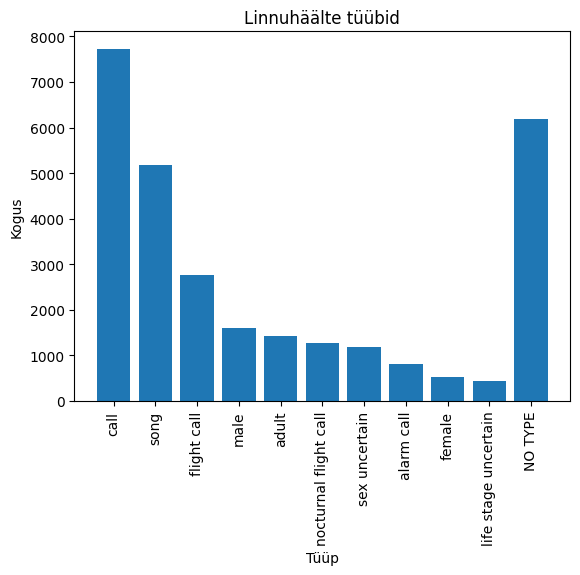

In [10]:
# Erinevate linnuhäälte tüüpide kogus andmestikus
types_value_counts = []
for frequent_type in frequent_types:
  types_value_counts.append(metadata[frequent_type].value_counts()[1])
empty_types = (metadata[frequent_types] == 0).all(axis=1).sum()
frequent_types.append("NO TYPE")
types_value_counts.append(empty_types)
plt.bar(frequent_types, types_value_counts)
plt.title("Linnuhäälte tüübid")
plt.xlabel("Tüüp")
plt.ylabel("Kogus")
plt.xticks(rotation=90)
plt.show()

Esimesel graafikul uuritakse heliklippide kogust ennustatavate liikide kohta. Sellelt on näha, et liigid, mida soovitakse ennustada pole eriti tasakaalus. On liike, millel on heliklippe üle 400, kuid samal ajal on osaldel liikidel kõigest 5 klippi. See võib põhjustada edaspidi probleeme, sest mudel ei pruugi olla võimeline liike ainult viie klipi pealt ennustama. Seetõttu on võib-olla mõeldav osade liikide mudelist välja jätmine ja ainult nende linnuliikide ennustamine, millel on klippe rohkem.

Teisest graafikust tulevad välja seosed liikide ja pikkus- ning laiuskraadide vahel. On näha, kuidas heliklippide salvestuskohad on klastrites, mis tähistavad erinevaid piirkondi, kust tulevad välja ka peamised seal pesitsevad linnuliigid. Osa linnuliike leidub mitmes eri paigas. See võib mõjutada nende lindude häält, sest nagu inimestel on ka osadel linnuliikidel dialektid.

Kolmandast graafikust on näha, millised on peamised linnuheli tüübid. Tüüpidest on alles jäetud ainult 10 kõige sagedasemat. Kõige sagedasemad on tüübid "call" ja "snog". Samas on siiski ka päris palju heliklippe, millel ei olnud üldse tüüpi või mille tüüp ei kuulu 10 sagedaseima hulka. Seega oleks seda atribuuti väga keeruline edaspidi kaasata, sest enamikel juhtudel see informatsioon on puudu.

### Mudel 1 - spektogrammid

Esimene mudel kasutab linnuliigi ennustamisel heliklippide spektogramme.

Mudel baseerub Tensorflow õpetusel nimega “Audio Data Preparation and Augmentation” (link õpetusele - https://www.tensorflow.org/io/tutorials/audio).

#### Andmete eeltöötlus

In [11]:
# Esimese mudeli jaoks vajalik eeltöötlus.
# Võtab argumentideks tee helifailini ja helifaili labeli
# Tagastab heliklipist tehtud spektogrammi ja labeli
def preprocess(file_path, label):
    audio = tfio.audio.AudioIOTensor(file_path, dtype=tf.int16)
    # audio_slice on praegu jäetud TF dokumentatsiooni näitest
    audio_slice = audio[100:]
    # Teeb 1-D tensoriks
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    # Normaliseerib
    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
    # Võtab kindla pikkusega osa, et iga klipp oleks sama pikkusega
    tensor = tensor[:150000]
    zero_padding = tf.zeros([150000] - tf.shape(tensor), dtype=tf.float32)
    wav = tf.concat([zero_padding, tensor],0)
    # Loob spektogrammi
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [12]:
# Kõigi failide sisse lugemine ja labeli numbri lisamine
# Oleme kasutanud 10 linnuliiki
liigid = ["commoo3", "gargan", "kenplo1", "nutman", "pursun4", "zitcis", "wemhar1", "woosan", "asbfly", "ashdro1"]
files = []
# Eeldatakse, et heliklipid asuvad liiginimelises kaustas
for i in range(len(liigid)):
  liik = liigid[i]
  # Leitakse kõigi heliklippide pathid
  liigi_failid = glob.glob(liik+"/*.ogg")
  for f in liigi_failid:
    files.append((f, i))

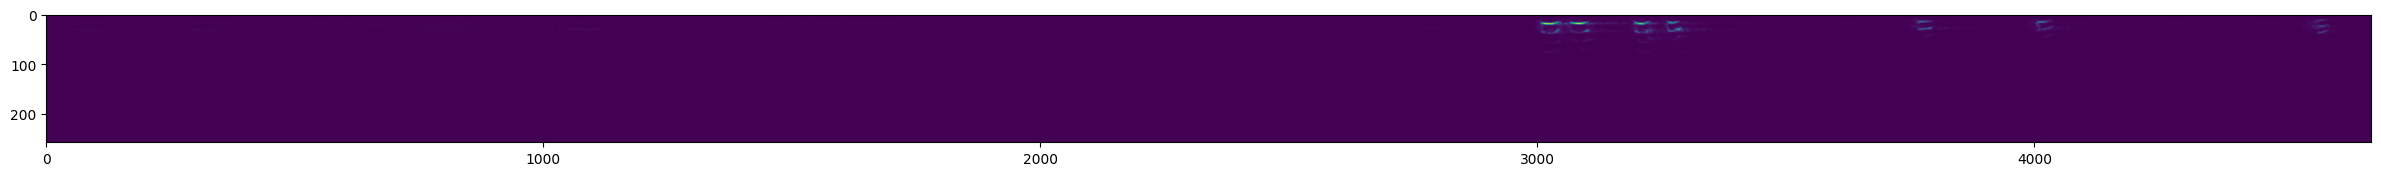

In [13]:
# Proovime eeltöötluse läbi ühe heliklipiga
s, l = preprocess(files[1][0], files[1][1])
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(s)[0])
plt.show()

In [14]:
# Teeme eeltöötluse kõigile olemasolevatele andmetele
X = []
y = []
for file_path, label in files:
  s, l = preprocess(file_path, label)
  X.append(s)
  y.append(l)

# Ennustatav atribuut ehk linnuliigid one-hot encodeitakse, et seda saaks mudelile ette anda
y = to_categorical(y, num_classes=10)
# Normaliseerimine ja reshapeime andmed
X = X / np.max(np.abs(X))
X = X[..., np.newaxis]
# Jagame andmed treening- ja testandmeteks 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Treeningandmed on mõõtmetega {X_train[0].shape}")

Treeningandmed on mõõtmetega (4678, 257, 1, 1)


#### Mudeli loomine

In [15]:
# Mudel 1 loomine
model = Sequential([
    Input(shape=(4678, 257, 1)),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
  	])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 4676, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2338, 127, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2336, 125, 16)       │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1168, 62, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1158656)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     148,308,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,311,866 (565.76 MB)

 Trainable params: 148,311,866 (565.76 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Mudeli treenimine - tehakse 20 epohhi
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 2.3046 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 364ms/step - loss: 2.1378 - precision: 0.6321 - recall: 0.0098
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 1.7372 - precision: 0.9634 - recall: 0.1627
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - loss: 1.3263 - precision: 0.9879 - recall: 0.3313
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - loss: 0.9490 - precision: 0.9703 - recall: 0.5360
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - loss: 0.8028 - precision: 0.9949 - recall: 0.6120
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - loss: 0.6534 - precision: 0.9868 - recall: 0.6637
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - loss: 0.8794 - precision: 0.9593 - recall: 0.6411
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - loss: 0.7971 - precision: 0.9837 - recall: 0.6413
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - lo

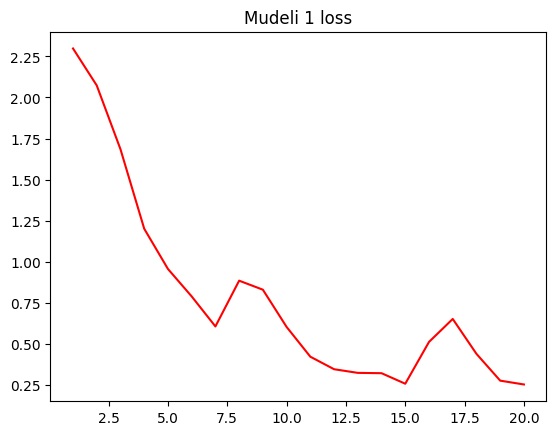

In [17]:
# Lossi jälgmine
plt.title("Mudeli 1 loss")
plt.plot(range(1, 21), hist.history["loss"], "r")
plt.show()

#### Mudeli testimine

In [18]:
# Mudeli peal testandmete ennustamine
y_pred = model.predict(X_test)
# Vaatame, mis klassi kõige tõenäolisemalt ennustatakse
y_pred_classes = np.argmax(y_pred, axis=1)
actual = np.argmax(y_test, axis=1)
# Vaatame, mis mudel ennustas ja mis oli tegelikult õige
print(f"Testandmeid on {len(X_test)}.")
for i in range(len(y_pred)):
    print(f"Ennustus: {y_pred_classes[i]}, Tegelik: {actual[i]}")
# Leiame täpsuse testandmetel
accuracy = accuracy_score(actual, y_pred_classes)
print("Täpsus:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 825ms/step
Testandmeid on 100.
Ennustus: 3, Tegelik: 7
Ennustus: 1, Tegelik: 1
Ennustus: 3, Tegelik: 7
Ennustus: 8, Tegelik: 3
Ennustus: 2, Tegelik: 2
Ennustus: 0, Tegelik: 7
Ennustus: 5, Tegelik: 7
Ennustus: 1, Tegelik: 2
Ennustus: 1, Tegelik: 1
Ennustus: 9, Tegelik: 9
Ennustus: 0, Tegelik: 0
Ennustus: 6, Tegelik: 3
Ennustus: 8, Tegelik: 8
Ennustus: 3, Tegelik: 1
Ennustus: 3, Tegelik: 7
Ennustus: 9, Tegelik: 7
Ennustus: 8, Tegelik: 9
Ennustus: 9, Tegelik: 0
Ennustus: 2, Tegelik: 6
Ennustus: 7, Tegelik: 8
Ennustus: 6, Tegelik: 9
Ennustus: 9, Tegelik: 9
Ennustus: 5, Tegelik: 5
Ennustus: 2, Tegelik: 7
Ennustus: 6, Tegelik: 1
Ennustus: 9, Tegelik: 9
Ennustus: 3, Tegelik: 9
Ennustus: 9, Tegelik: 4
Ennustus: 7, Tegelik: 2
Ennustus: 5, Tegelik: 6
Ennustus: 4, Tegelik: 9
Ennustus: 5, Tegelik: 6
Ennustus: 9, Tegelik: 8
Ennustus: 8, Tegelik: 3
Ennustus: 2, Tegelik: 0
Ennustus: 7, Tegelik: 6
Ennustus: 9, Tegelik: 8
Ennustus: 3, Tegelik: 1
Ennustus: 8, Tegelik: 4
Ennus

#### Mudeli 1 edasised katsetused
Mudeli 1 edasikatsetusena proovime jaotada ühte heliklippi mitmeks klipiks. Proovime näha, kas sellel võiks olla positiivne mõju. Kahjuks ei jõudnud seda lõpetada ehk osad plokid on välja kommenteeritud. Aga idee jätsime alles, et oleks näha, et proovisime mudeli eeltöötlust edasi arendada.

In [19]:
# Laeb heliklipi, teeb audiotensoriks, resampleb 16 kHz monochanneliks
# Võtab argumendiks tee failini
# Tagastab modifitseeritud heliklipi
def load_ogg_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    # Muudab tensoriks ja paneb channelid kokku
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Võtab sample ratei
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resampleb 16 kHz
    ogg = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return ogg

In [20]:
# Eeltöötluse testimine ühel heliklipil
klipi_nimi = "woosan/XC25111.ogg"
klipp = load_ogg_16k_mono(klipi_nimi)

In [21]:
# Eeltöötlus andmetele
def preprocess_ogg(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# Andmete eeltöötlus
'''
X_2 = []
y_2 = []

liigid = ["commoo3", "gargan", "kenplo1", "nutman", "pursun4", "zitcis", "wemhar1", "woosan", "asbfly", "ashdro1"]
files = []
# Eeltöötluse katsetamine
liik = liigid[0]
liigi_failid = glob.glob(liik+"/*.ogg")

for f in liigi_failid[:10]:
  klipp = load_ogg_16k_mono(f)

  audio_slices = tf.keras.utils.timeseries_dataset_from_array(klipp, klipp, sequence_length=16000, sequence_stride=16000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_ogg)
  audio_slices = audio_slices.batch(64)

  for s in audio_slices:
    for el in s:
      X.append(el)
      y.append(0)
'''

In [ ]:
# Mudel 1.2
'''
model = Sequential([
    Input(shape=(1491, 257, 1)),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
  	])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
'''

In [ ]:
#hist = model.fit(X_2, y_2, epochs = 4, batch_size = 32)

In [ ]:
'''
plt.title("Mudeli 1.2 loss")
plt.plot(range(1, 21), hist.history["loss"], "r")
plt.show()
'''

### Mudel 2 - MFCCs
"Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio."

Audiote klassifitseerimisel on lisaks võimalik kasutada MFCCs. Kuna MFCCs väljund on teistsugune võrreldes spektogrammi omaga, on põneva näha kuidas mudelid omavahel erinevad ja milline neist paremini ennustab.

Mudel baseerub Mediumi artiklil “Unveiling the Magic of Voice Classification with MFCC and DNN” (link - https://medium.com/@muradatcorvit23/unveiling-the-magic-of-voice-classification-with-mfcc-and-dnn-196830bbff80).

#### Eeltöötlus

In [23]:
# Failide eeltöötlus, võtav sisendiks järjendi, kus on ennikud, mille esimesel kohal on audiofaili tee ja teisel kohal label numbrina
# Vaikeväärtustena on sr - Sample rate = 22050, n_mfcc = 13, seg_len - Segmenth length in seconds = 5

# Kõike võib vastavalt vajadusele muuta, ühes kohas, funktsiooni päises
# sr = 22050 või 44100?, ei tea kas 44100 läheks paljuks
# n_mfcc = 13, kuid suurem peaks parem olema, ent mingisuguse maani
# seg_len = 5, kuidas soovime
def process_files(files, sr = 22050, n_mfcc=13, seg_len = 5):
  # Kogume eraldi kokku MFCCs ja labelid
  segment_mfccs = []
  labels = []
  # Käime läbi kõik etteantud failid
  for file_path, label in files:
    audio, sr = librosa.load(file_path, sr=sr)
    # Võtame tervest audiost kindla pikkusega sämpli.
    sample_segment_len = int(seg_len * sr)
    #Kontrollime, et audio oleks ikka korrektse pikkusega.
    #Kui ei ole, paddime vaikusega (0-idega)
    if len(audio) < sample_segment_len:
      padding = sample_segment_len - len(audio)
      audio = np.pad(audio, (0, padding), 'constant')

    # Kindla pikkusega klipp võetakse suvaliselt. Ei ole grantiid, et see klipp ei ole vaikus vms.
    # Ideaalis võiks võtta klipi, milles on kõige enam infot
    # Hea kasutada kui ei saa eraldada nii palju ajalist ressurssi
    #start_sample = random.randint(0, (len(audio) - sample_segment_len))
    #sample = audio[start_sample:(start_sample + sample_segment_len)]

    # Valime heliklipist jupi potentsiaalselt "suurima energiaga"
    # See võib failide arvu kasvades kulukaks tööks minna
    if len(audio) > sample_segment_len:
      segments = int(len(audio) / sample_segment_len)
      energy = [np.sum(np.square(audio[i * sample_segment_len:(i + 1) * sample_segment_len])) for i in range(segments)]
      valik = np.argmax(energy)
      start_sample = valik * sample_segment_len
      sample = audio[start_sample:start_sample + sample_segment_len]
    else:
      sample = audio

    # Normaliseerimine
    sample = librosa.util.normalize(sample)
    # MFCCs võtmine.
    mfccs = librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=13)
    segment_mfccs.append(mfccs)
    labels.append(label)
  return segment_mfccs, labels

In [24]:
# Võtame 10 linnuliiki ja igaühel on 50 heliklippi
liigid = ['asbfly', 'ashdro1', 'commoo3', 'gargan', 'kenplo1', 'nutman', 'pursun4', 'wemhar1', 'woosan', 'zitcis']

In [25]:
# Kõigi failide sisse lugemine ja labeli numbri lisamine
files = []
for i in range(len(liigid)):
  liik = liigid[i]
  liigi_failid = glob.glob(liik+"/*.ogg")
  for f in liigi_failid:
    files.append((f, i))
# Ajan järjendis heliklipid segamine, et edaspidi oleks lihtsam treening ja testandmeteks jagada
np.random.shuffle(files)

In [36]:
# Andmete eeltöötlus
X, y = process_files(files)
#Klasside numbrid dünaamiliselt ja traintest suuruse määramine. Hetkel on testandmete suurus 20%
num_of_classes = len(np.unique(y)) + 1
traintest_size = 0.2
# Ennustava atribuudi one-hot encodimine, et seda anda mudelile ette
y = to_categorical(y, num_classes=num_of_classes)

# Probleem: andmed on arrayde arrayd, flattenib iga array X-is, et sobiks standarscalerile
# Teeb listi 2D arrayks
X_flattened = np.array([item.flatten() for item in X])

# StandardScaleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# Rehsape tagasi
feature_count = X[0].shape[0]
time_steps = X[0].shape[1]
X_scaled = X_scaled.reshape(len(X_scaled), feature_count, time_steps, 1)

# Train test split
test_len = int(len(X_scaled) * traintest_size)
X_train = X_scaled[test_len:]
y_train = y[test_len:]
X_test = X_scaled[:test_len]
y_test = y[:test_len]

#### Mudeli loomine

In [44]:
# Mudeli loomine
model2 = Sequential([
    Input(shape=(feature_count, time_steps, 1)),
    Conv2D(16, (3, 3), activation="relu", padding="same"),
    Dropout(0.25),
    Conv2D(16, (3, 3), activation="relu", padding="same"),
    Flatten(),
    Dense(24, activation="relu"),
    Dropout(0.5),
    Dense(num_of_classes, activation="softmax")
])

# Compile ja fit
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model2.summary()
hist = model2.fit(X_train, y_train, epochs=20, batch_size=32)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 13, 216, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 13, 216, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 13, 216, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 44928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 24)                  │       1,078,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 11)                  │             275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,051 (4.12 MB)

 Trainable params: 1,081,051 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.1102 - loss: 2.9357
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1255 - loss: 2.3575
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1031 - loss: 2.3427
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1390 - loss: 2.3248
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1570 - loss: 2.3143
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1281 - loss: 2.2770
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1355 - loss: 2.2554
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1315 - loss: 2.2255
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1425 - loss: 2.1710
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1312 - loss: 2.1873
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2085 - loss: 2.1397
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2036 - 

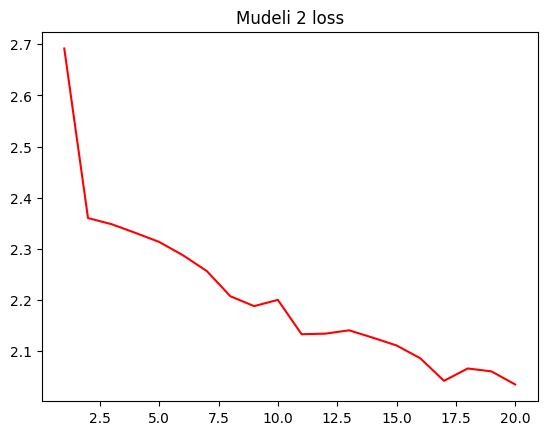

In [45]:
plt.title("Mudeli 2 loss")
plt.plot(range(1, 21), hist.history["loss"], "r")
plt.show()

#### Mudeli testimine

In [46]:
# Mudeli testimine testandmetel
pred = model2.predict(X_test)
correct = 0

print(f"Testandmeid on {len(X_test)}.")
# Vaadatakse palju testandmetest mudel õigesti ennustab
for i in range(len(pred)):
    predicted_label = np.argmax(pred[i])
    actual_label = np.argmax(y_test[i])
    print(f"Ennustus: {predicted_label}")
    print(f"Tegelik: {actual_label}")
    if predicted_label == actual_label:
        correct += 1
    print()

accuracy = correct / len(pred)
print(f"Täpsus: {accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Testandmeid on 100.
Ennustus: 1
Tegelik: 3

Ennustus: 3
Tegelik: 8

Ennustus: 5
Tegelik: 4

Ennustus: 1
Tegelik: 6

Ennustus: 0
Tegelik: 9

Ennustus: 9
Tegelik: 6

Ennustus: 0
Tegelik: 4

Ennustus: 3
Tegelik: 2

Ennustus: 3
Tegelik: 3

Ennustus: 5
Tegelik: 7

Ennustus: 9
Tegelik: 0

Ennustus: 0
Tegelik: 0

Ennustus: 1
Tegelik: 0

Ennustus: 1
Tegelik: 1

Ennustus: 2
Tegelik: 6

Ennustus: 5
Tegelik: 1

Ennustus: 1
Tegelik: 6

Ennustus: 1
Tegelik: 3

Ennustus: 1
Tegelik: 9

Ennustus: 5
Tegelik: 2

Ennustus: 5
Tegelik: 5

Ennustus: 1
Tegelik: 7

Ennustus: 0
Tegelik: 1

Ennustus: 1
Tegelik: 8

Ennustus: 0
Tegelik: 2

Ennustus: 2
Tegelik: 2

Ennustus: 1
Tegelik: 5

Ennustus: 3
Tegelik: 3

Ennustus: 2
Tegelik: 7

Ennustus: 5
Tegelik: 5

Ennustus: 2
Tegelik: 2

Ennustus: 1
Tegelik: 5

Ennustus: 2
Tegelik: 5

Ennustus: 1
Tegelik: 2

Ennustus: 0
Tegelik: 9

Ennustus: 0
Tegelik: 4

Ennustus: 2
Tegelik: 1

Ennustus: 3
Tegelik: 8

Ennustus: 0
Tegelik: 7

Ennust

#### Mudeli testimine väiksematel andmetele
Siin saab teist mudelit katsetada väiksematel andmemahtudel ehk ennustatakse ainult kolme linnuliiki.

In [47]:
# Väiksemaks testimiseks võetakse 3 liiki
liigid = ["asbflytest", "blakit1test", "categrtest"]

In [48]:
# Kõigi failide sisse lugemine ja labeli numbri lisamine
files = []
for i in range(len(liigid)):
  liik = liigid[i]
  liigi_failid = glob.glob(liik+"/*.ogg")
  for f in liigi_failid:
    files.append((f, i))
# Ajan järjendis heliklipid segamine, et edaspidi oleks lihtsam treening ja testandmeteks jagada
np.random.shuffle(files)

In [49]:
# Andmete eeltöötlus
X, y = process_files(files)
#Klasside numbrid dünaamiliselt ja traintest suuruse määramine
num_of_classes = len(np.unique(y)) + 1
traintest_size = 0.2

# Ennustava atribuudi one-hot encodimine, et seda anda mudelile ette
y = to_categorical(y, num_classes=num_of_classes)

# Probleem: andmed on arrayde arrayd, flattenib iga array X-is, et sobiks standarscalerile
# Teeb listi 2D arrayks
X_flattened = np.array([item.flatten() for item in X])

# StandardScaleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# Rehsape tagasi
feature_count = X[0].shape[0]
time_steps = X[0].shape[1]
X_scaled = X_scaled.reshape(len(X_scaled), feature_count, time_steps, 1)

# Train test split
test_len = int(len(X_scaled) * traintest_size)
X_train = X_scaled[test_len:]
y_train = y[test_len:]
X_test = X_scaled[:test_len]
y_test = y[:test_len]

In [50]:
# Mudeli loomine
model2 = Sequential([
    Input(shape=(feature_count, time_steps, 1)),
    Conv2D(16, (3, 3), activation="relu", padding="same"),
    Dropout(0.25),
    Conv2D(16, (3, 3), activation="relu", padding="same"),
    Flatten(),
    Dense(24, activation="relu"),
    Dropout(0.5),
    Dense(num_of_classes, activation="softmax")
])

# Compile ja fit
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model2.summary()
model2.fit(X_train, y_train, epochs=5, batch_size=32)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 13, 216, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 13, 216, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 13, 216, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 44928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 24)                  │       1,078,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │              75 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,080,851 (4.12 MB)

 Trainable params: 1,080,851 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2308 - loss: 1.0415
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5385 - loss: 4.8890
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5385 - loss: 1.1240
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6923 - loss: 0.8779
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6154 - loss: 0.5127


In [51]:
# Mudeli testimine testandmetel
pred = model2.predict(X_test)
correct = 0

print(f"Testandmeid on {len(X_test)}.")
# Vaadatakse palju testandmetest mudel õigesti ennustab
for i in range(len(pred)):
    predicted_label = np.argmax(pred[i])
    actual_label = np.argmax(y_test[i])
    print(f"Ennustus: {predicted_label}")
    print(f"Tegelik: {actual_label}")
    if predicted_label == actual_label:
        correct += 1
    print()

accuracy = correct / len(pred)
print(f"Täpsus: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Testandmeid on 3.
Ennustus: 2
Tegelik: 2

Ennustus: 2
Tegelik: 2

Ennustus: 2
Tegelik: 0

Täpsus: 66.67%


### Tulemused

Mudel 1 tegi etteantud heliklippidest spektogrammid ja ennustas nende alusel linnuliike. Treenimine toimus 20 epohhi vältel. Lossi diagrammil on näha, kuidas loss ilusti kahaneb ja jääb lõpuks 0.25-0.3 lähedale. Testandmetel saavutatakse täpsus 22%. Juhusliku valikuga oleks täpsus 10% ehk juhuslikust valikust on mudel 2 korda parem.

Mudel 2 kasutas heliklippide MFCCs, et ennustada linnuliike. Treenimine toimus 20 epohhi vältel. Lossi diagrammil on näha, et kuigi loss väheneb, siis ei jõua see eriti madalale. Lõpuks jääb see 2.1 juurde, mis on võrreldes mudeliga 1 4 korda suurem. Testandmetel saavutatakse täpsus 16%. On märgata, et mudel on üpris ebastabiilne, sest erinevatel jooksutamistel suudab see vahel rohkem ennustada. Samas testides mudelit vähematel linnuliikidel suudab mudel kordades paremini ennustada.

Mõlema mudeli puhul aitaks tulemust parandada andmete juurde lisamine ja epohhide arvu tõstmine. On näha, et 50 heliklipiga liigi kohta ei suudeta häid tulemusi saavutada. Samas nõuab rohkem andmeid rohkem mälu ja aega treenimisel. Kokkuvõtlikult töötavad mõlemad mudelid paremini kui juhuslik valik ning neil on edasist potentsiaali edasiarenduseks.

